In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, datetime
import matplotlib.pyplot as plt
from missingpy import KNNImputer
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from time import time

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
features = pd.read_csv("sensors.csv")

In [3]:
target = pd.read_csv("coke_target.csv")

In [4]:
data = pd.merge(features, target, how = 'left', on = 'timestamp')

In [5]:
## ищем фичи, в которых слишком много пропусков, их заполнять не будем

def get_nan_cols(df, nan_percent=0.05):
    threshold = len(df.index) * nan_percent
    return [c for c in df.columns if sum(df[c].isnull()) >= threshold]  

In [6]:
get_nan_cols(data)

['f_0',
 'f_1',
 'f_2',
 'f_36',
 'f_37',
 'f_38',
 'f_39',
 'f_40',
 'f_41',
 'f_42',
 'target']

In [7]:
## генерим временные фичи

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['time'] = data['timestamp'].dt.strftime("%Y%m%d%H%M%S")
data['time'] = data['time'].astype(float) / 10000
data['month'] = (data['time'].astype(str).str[4:6]).astype(int)
data['hour'] = (data['time'].astype(str).str[8:10]).astype(int)
data['day'] = data['timestamp'].dt.dayofweek
data['week'] = data['timestamp'].dt.weekofyear
data['beg'] = data['timestamp'].dt.is_month_start
data['end'] = data['timestamp'].dt.is_month_end

In [8]:
## список фичей, по которым будут заполняться пропуски

list1 = ['f_3', 'f_4', 'f_5', 'f_6', 'f_7',
       'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34',
       'f_35', 'f_43','f_36', 'f_37', 'f_38', 'f_39', 'f_40',
       'f_44', 'f_45', 'f_46', 'f_47', 'time', 'month', 'hour', 'day', 'week', 'beg', 'end']

In [9]:
train = data[~data['target'].isnull()]
test = data[data['target'].isnull()]
[len(train), len(test)]

[10400, 2872]

In [10]:
## заполняем пропуски KNN: обучаем на трейне, заполняем трейн и тест

imputer = KNNImputer()
imp = imputer.fit(train[list1])
data[list1] = imp.transform(data[list1])

C:\ProgramData\Anaconda3\lib\site-packages\missingpy\knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
C:\ProgramData\Anaconda3\lib\site-packages\missingpy\knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
C:\ProgramData\Anaconda3\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [11]:
train = data[~data['target'].isnull()]
test = data[data['target'].isnull()]
[len(train), len(test)]

[10400, 2872]

In [12]:
## заменяем "странные" отрицательные значения фичей на нули

list3 = ['f_3', 'f_4', 'f_5', 'f_6', 'f_7',
       'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34',
       'f_35', 'f_43','f_36', 'f_37', 'f_38', 'f_39', 'f_40',
       'f_44', 'f_45', 'f_46', 'f_47', 'time', 'month', 'hour', 'day', 'week', 'beg', 'end']
for feature in list3:
    train[str(feature)][train[str(feature)] < 0] = 0
    test[str(feature)][test[str(feature)] < 0] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_

In [13]:
## список фичей для Bagging (отбирались те, что без пропусков + по feature importance)

list1 = ['f_3', 'f_4', 'f_5', 'f_6', 'f_7',
       'f_8', 'f_9', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
        'f_18', 'f_20', 'f_21', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34',
       'f_35', 'f_43',
       'f_44', 'f_45', 'f_46', 'f_47', 'time', 'month', 'hour']

In [14]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [15]:
## Bagging - на всякий случай для устойчивости усредняем прогнозы с 10 разными random state

subm_bag = 0.0
num_ensembles = 10
for i in tqdm(range(num_ensembles)):
    Xtrn, Xtest, Ytrn, Ytest = train_test_split(train[list1], train['target'], random_state = 42, test_size = 0.25, shuffle = False)
    bag = BaggingRegressor(n_estimators = 8, random_state = 42 * i, max_features = 0.6).fit(Xtrn, Ytrn)
    test_bag = bag.predict(Xtest)
    rmse2 = rmse(test_bag, Ytest)
    bag = BaggingRegressor(n_estimators = 8, random_state = 42 * i, max_features = 0.6).fit(train[list1], train['target'])
    subm_bag += bag.predict(test[list1])
    print('rmse_bag', rmse2.mean())
subm_bag = subm_bag / num_ensembles

  0%|          | 0/10 [00:00<?, ?it/s]

rmse_bag 0.6158838232691348


 10%|█         | 1/10 [00:02<00:25,  2.88s/it]

rmse_bag 0.609185071189205


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

rmse_bag 0.6886750883708709


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

rmse_bag 0.6843451353988653


 40%|████      | 4/10 [00:11<00:17,  2.96s/it]

rmse_bag 0.6328695658166463


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

rmse_bag 0.7038332328053563


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

rmse_bag 0.6668059428104121


 70%|███████   | 7/10 [00:21<00:09,  3.11s/it]

rmse_bag 0.637812937746868


 80%|████████  | 8/10 [00:24<00:06,  3.28s/it]

rmse_bag 0.6335258929409282


 90%|█████████ | 9/10 [00:27<00:03,  3.26s/it]

rmse_bag 0.6377995549234003


100%|██████████| 10/10 [00:31<00:00,  3.37s/it]


In [16]:
## список фичей для lightgbm (отбирались по feature importance, могут быть фичи с пропусками)

list2 = ['f_3', 'f_4', 'f_5', 'f_6', 'f_7',
       'f_9', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_18', 'f_20', 'f_21', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34',
       'f_35', 'f_43',
       'f_44', 'f_45', 'f_46', 'f_47']

In [17]:
##lightgbm - на всякий случай для устойчивости усредняем прогнозы с 10 разными random state

subm_gbm = 0.0
num_ensembles = 10
for i in tqdm(range(num_ensembles)):
    Xtrn, Xtest, Ytrn, Ytest = train_test_split(train[list2], train['target'], random_state = 42, test_size = 0.25, shuffle = False)
    gbm = lgb.LGBMRegressor(boosting_type = 'gbdt', num_boost_round = int(0.09 * len(Xtrn)), objective = 'mse', num_leaves = 2, 
        learning_rate = 0.1, feature_fraction = 0.6, bagging_fraction= 0.8, bagging_freq= 5, seed= 42 * i, boost_from_average= True,
        reg_sqrt = True, min_child_samples = int(0.05 * len(Xtrn))).fit(Xtrn, Ytrn)
    test_gbm = gbm.predict(Xtest)
    rmse2 = rmse(test_gbm, Ytest)
    gbm = lgb.LGBMRegressor(boosting_type = 'gbdt', num_boost_round = int(0.09 * len(train)), objective = 'mse', num_leaves = 2, 
        learning_rate = 0.1, feature_fraction = 0.6, bagging_fraction= 0.8, bagging_freq= 5, seed= 42 * i, boost_from_average= True,
        reg_sqrt = True, min_child_samples = int(0.05 * len(train))).fit(train[list2], train['target'])
    subm_gbm += gbm.predict(test[list2])
    print('rmse_gbm', rmse2.mean())
subm_gbm = subm_gbm / num_ensembles

  0%|          | 0/10 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.6059731367322435


 10%|█         | 1/10 [00:01<00:09,  1.02s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.603884547295567


 20%|██        | 2/10 [00:02<00:08,  1.04s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.597900938460545


 30%|███       | 3/10 [00:02<00:06,  1.01it/s]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.603286069451399


 40%|████      | 4/10 [00:04<00:06,  1.03s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.6034154567065813


 50%|█████     | 5/10 [00:05<00:05,  1.02s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.5995151316435084


 60%|██████    | 6/10 [00:06<00:04,  1.02s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.5989419801517069


 70%|███████   | 7/10 [00:07<00:03,  1.01s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.6061873582154228


 80%|████████  | 8/10 [00:08<00:02,  1.02s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.6026334523221089


 90%|█████████ | 9/10 [00:09<00:01,  1.02s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 0.6038924735517797


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


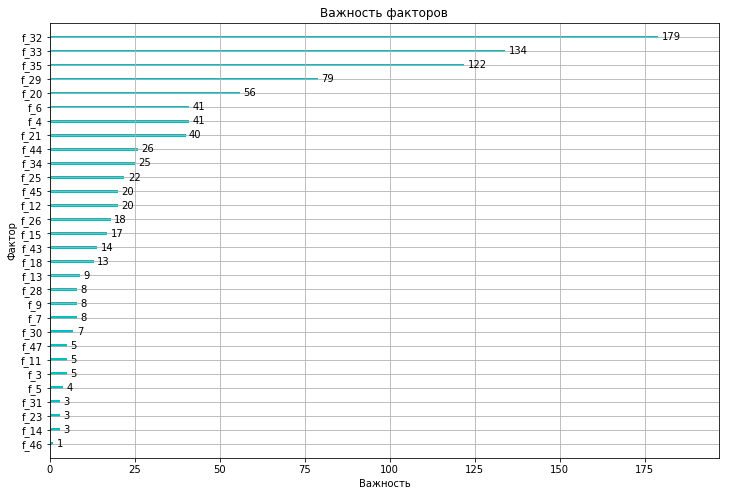

In [18]:
plt.rcParams["figure.figsize"] = (12, 8)
ax = lgb.plot_importance(gbm, max_num_features = 100, color = 'c')
plt.title('Важность факторов')
plt.xlabel('Важность')
plt.ylabel('Фактор')
plt.show()

In [19]:
ser = pd.Series(np.array(data['target']), index = data['timestamp'])
train2 = ser[~ser.isnull()]
test2 = ser[ser.isnull()]
train1, test1 = ser.iloc[:8500], ser.iloc[8500:10400]

In [20]:
## дальше пробовали выделить тренд и сезонность (пробовали 12, 24, 24 * 7) с помощью holt-winters и экспоненциального сглаживания:
## ничего не нашлось, оставили экспоненциальное сглаживание, которое дает наивный прогноз последней точки
## в надежде, что в будущем может появиться сезонность и она поймается

model3 = ExponentialSmoothing(train1, seasonal='mult', seasonal_periods = 24).fit()
pred3 = model3.predict(start=test1.index[0], end=test1.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.3154394863032125


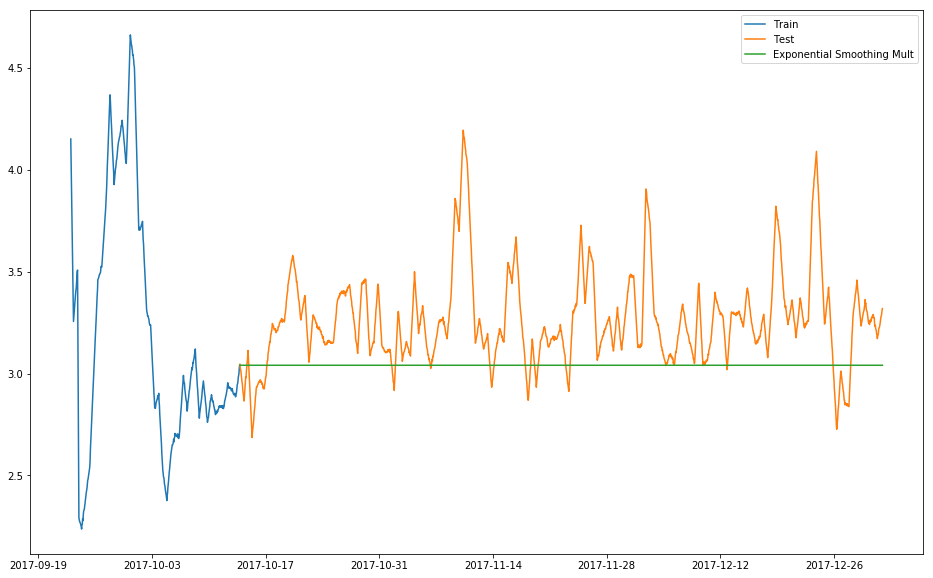

In [21]:
plt.rcParams["figure.figsize"] = (16, 10)
plt.plot(train1.index[8000:], train1[8000:], label='Train')
plt.plot(test1.index, test1, label='Test')
plt.plot(pred3.index, pred3, label='Exponential Smoothing Mult')
plt.legend(loc='best')
print(rmse(pred3, test1))

In [22]:
model2 = ExponentialSmoothing(train2[8060:], seasonal='mult', seasonal_periods = 24).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [23]:
## блендим неудавшееся экспоненциальное сглаживание с моделями ML: 
## берем отклонения моделей от их среднего прогноза, 
## затем блендим эти отклонения линейной комбинацией (50% на 50% - подбиралось по CV), 
## затем отстраиваем блендинг отклонений от полученного экс. сглаживанием прогноза

pred_gbm = (- np.mean(subm_gbm) + subm_gbm) 
pred_bag = (- np.mean(subm_bag) + subm_bag) 
pred3 = np.array(pred2) + 0.5 * (pred_gbm) + 0.5 * (pred_bag)

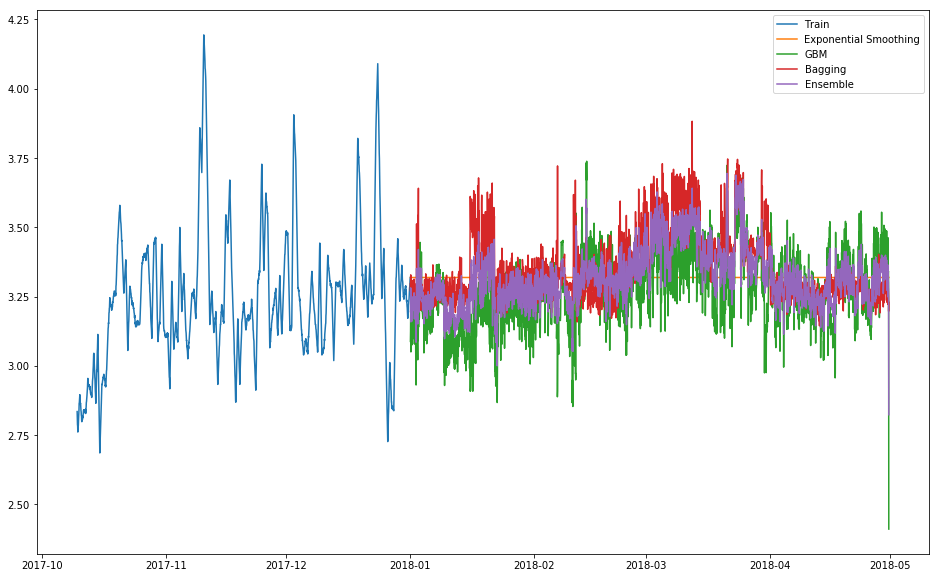

In [24]:
plt.rcParams["figure.figsize"] = (16, 10)
plt.plot(train2.index[-2000:], train2[-2000:], label='Train')
plt.plot(pred2.index, pred2, label='Exponential Smoothing')
plt.plot(pred2.index, subm_gbm, label='GBM')
plt.plot(pred2.index, subm_bag, label='Bagging')
plt.plot(pred2.index, pred3, label='Ensemble')
plt.legend(loc='best')

In [25]:
## итоговый сабмит

subm = 0.0 * (0.0 * subm_gbm + 0.0 * subm_bag) + 0.0 * np.array(pred2) + 1.0 * np.array(pred3)

In [26]:
subm

array([3.19579378, 3.2012192 , 3.28152825, ..., 3.29994037, 3.2159491 ,
       2.82374389])

In [27]:
subm = pd.Series(subm, name = 'target', index = test2.index)

In [28]:
subm.to_csv("subm_" + str(time()) + ".csv", header = ['target'], index_label = ['timestamp'])